Helpful info on Pandas:
https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import numpy as np

In [2]:
engine = create_engine('sqlite:///guam_forest_survey.db')

# Find plots which were sampled in 2002 and 2013

In [3]:
pd.options.display.max_rows = 4
df_plot = pd.read_sql_query('''
    select PLOT, COUNT(*)  AS years_sampled
    from gu_plot
    where PLOT_STATUS_CD = 1
    group by PLOT
    order by PLOT
    ''', engine)
df_plot = df_plot[df_plot.years_sampled==2]
df_plot = df_plot.drop('years_sampled',1)
df_plot

,PLOT
0,66007
1,66008
...,...
47,66131
48,66133


# Count trees (DBH >= 5 in) in plots sampled in 2002 and 2013

In [4]:
pd.options.display.max_rows = 6
df_tree = pd.read_sql_query(''' 
    select GENUS, SPECIES, COMMON_NAME, PLOT, INVYR 
    from gu_tree, ref_species 
    where 
        gu_tree.SPCD = ref_species.SPCD
        and DIA >= 5
    ''', engine)
df_tree['TREE_NAME'] = df_tree.GENUS + ' ' + df_tree.SPECIES + ' (' + df_tree.COMMON_NAME + ')'
df_tree = df_tree[['PLOT','INVYR','TREE_NAME']] # 1592 trees (rows)
df_tree = pd.merge(df_plot, df_tree) # 1548 trees in plots sampled in 2002 and 2013
df_tree

,PLOT,INVYR,TREE_NAME
0,66007,2002,Ficus prolixa (aoa)
1,66007,2002,Macaranga thompsonii (Macaranga thompsonii)
2,66007,2002,Aglaia mariannensis (Titimel)
...,...,...,...
1545,66133,2013,Hibiscus tiliaceus (sea hibiscus)
1546,66133,2013,Hibiscus tiliaceus (sea hibiscus)
1547,66133,2013,Hibiscus tiliaceus (sea hibiscus)


# List tree species

In [5]:
tree_list = sorted(df_tree.TREE_NAME.unique())
i = 0
for tree in tree_list:
    print(i, tree)
    i += 1

0 Adenanthera pavonina (red beadtree)
1 Aglaia mariannensis (Titimel)
2 Annona muricata (soursop)
3 Annona reticulata (custard apple)
4 Areca catechu (betelnut)
5 Artocarpus altilis (breadfruit)
6 Artocarpus mariannensis (dugdug, Marianas breadfruit)
7 Averrhoa bilimbi (Bilimbi)
8 Barringtonia asiatica (sea putat)
9 Barringtonia racemosa (langaasag)
10 Bauhinia monandra (Napoleon's plume)
11 Calophyllum inophyllum (Alexandrian laurel)
12 Cananga odorata (ilang-ilang)
13 Carica papaya (papaya)
14 Casuarina equisetifolia (beach sheoak)
15 Ceiba pentandra (kapoktree)
16 Cerbera dilatata (chuti)
17 Cocos nucifera (coconut palm)
18 Cyathea lunulata (olioli)
19 Cycas circinalis (queen sago)
20 Eugenia palumbis (agatelang)
21 Eugenia thompsonii (atoto)
22 Ficus prolixa (aoa)
23 Ficus tinctoria (mati)
24 Glochidion marianum (Glochidion marianum)
25 Guamia mariannae (paipai)
26 Hernandia ovigera (Hernandia ovigera)
27 Hernandia sonora (mago)
28 Heterospathe elata (palma brava)
29 Hibiscus tilia

# Change Analysis: Find significant differences in number of trees observed in 2002 and 2013

In [6]:
pd.options.display.max_rows = 6
df_tree_counts = pd.crosstab([df_tree.TREE_NAME,df_tree.PLOT], df_tree.INVYR)
df_tree_counts

INVYR                                            2002  2013
TREE_NAME                                 PLOT             
Adenanthera pavonina (red beadtree)       66028     2     1
                                          66054     2     5
Aglaia mariannensis (Titimel)             66007     5     4
...                                               ...   ...
Vitex parviflora (smallflower chastetree) 66110    10    11
                                          66118     2     2
Xylosma nelsonii (Xylosma nelsonii)       66067     1     0

[204 rows x 2 columns]

In [7]:
pd.options.display.max_rows = 100
tree = tree_list[17]
print(tree)
df_tree_counts.loc[tree]

Cocos nucifera (coconut palm)


INVYR,2002,2013
PLOT,,
66044,5,5
66067,1,0
66074,0,5
66100,1,3
66101,16,16
66104,8,0
66110,19,23
66117,1,2
66118,13,19


In [8]:
pd.options.display.max_rows = 6
df_tree_counts_summary = pd.crosstab([df_tree.TREE_NAME], df_tree.INVYR)
df_tree_counts_summary

INVYR,2002,2013
TREE_NAME,,
Adenanthera pavonina (red beadtree),4,6
Aglaia mariannensis (Titimel),22,18
Annona muricata (soursop),0,1
...,...,...
Tristiropsis obtusangula (faia),0,6
Vitex parviflora (smallflower chastetree),63,135
Xylosma nelsonii (Xylosma nelsonii),1,0


In [9]:
import readline
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula

coin = importr('coin')
base = importr('base')
pandas2ri.activate()

def plot_count(tree):
    '''
    Returns a dict containing of the number of observations for the tree in 2002 and 2013.
    '''
    mydict = df_tree_counts.loc[tree].to_dict()
    plots = list(mydict[2002].keys())
    n2002 = list(mydict[2002].values())
    n2013 = list(mydict[2013].values())
    return({'plots': plots, '2002': n2002, '2013': n2013})
    
def wilcox_sign_test(tree):
    mydict = plot_count(tree)
    if mydict['2002']==mydict['2013']:
        return('Cannot estimate p-value because n2002 and n2013 are equal.')
    else:
        mydf = pd.DataFrame({'n2002': mydict['2002'], 'n2013': mydict['2013']})
        robjects.globalenv['dataframe'] = mydf
        result = coin.wilcoxsign_test(Formula('n2013 ~ n2002'), data=base.as_symbol('dataframe'))
        return(result)

def extract_p_value(result):
    import re
    s = str(result)
    p = re.compile('p-value = (\d+\.\d+)')
    m = p.findall(s)
    if m:
        p_value = float(m[0])
    else:
        p_value = None
    return(p_value)

# The following is test code which may be commented out.
tree = tree_list[17]
plot_count_result = plot_count(tree)
print('{} was observed in {} of 42 plots in the 2002 and 2013 surveys:'.format(tree, len(plot_count_result['plots'])))
print()
print(plot_count_result)
myresult = wilcox_sign_test(tree)
print(myresult)

p = extract_p_value(myresult)
print('p: {}'.format(p))

Cocos nucifera (coconut palm) was observed in 11 of 42 plots in the 2002 and 2013 surveys:

{'plots': [66131, 66067, 66100, 66101, 66118, 66104, 66124, 66074, 66044, 66110, 66117], '2013': [12, 0, 3, 16, 19, 0, 8, 5, 5, 23, 2], '2002': [10, 1, 1, 16, 13, 8, 7, 0, 5, 19, 1]}

	Asymptotic Wilcoxon-Pratt Signed-Rank Test

data:  y by x (pos, neg) 
	 stratified by block
Z = 1.478, p-value = 0.1394
alternative hypothesis: true mu is not equal to 0


p: 0.1394


In [10]:
pd.options.display.max_rows = 100

# Make a list of p-values and add to df_tree_counts_summary
mylist = []
for tree in tree_list:
    p = extract_p_value(wilcox_sign_test(tree))
    mylist.append(p)
df_tree_counts_summary['p'] = mylist
df_tree_counts_summary

# Make a list of plot counts and add to df_tree_counts_summary
mylist = []
for tree in tree_list:
    mylist.append(len(plot_count(tree)['plots']))
df_tree_counts_summary['n_plots'] = mylist
df_tree_counts_summary

INVYR,2002,2013,p,n_plots
TREE_NAME,,,,
Adenanthera pavonina (red beadtree),4,6,0.654700,2
Aglaia mariannensis (Titimel),22,18,0.890700,5
Annona muricata (soursop),0,1,0.317300,1
Annona reticulata (custard apple),6,15,0.165500,3
Areca catechu (betelnut),3,12,0.104100,5
Artocarpus altilis (breadfruit),8,6,0.492200,5
"Artocarpus mariannensis (dugdug, Marianas breadfruit)",1,3,0.317300,4
Averrhoa bilimbi (Bilimbi),4,9,0.179700,2
Barringtonia asiatica (sea putat),2,3,0.317300,1


/home/aubreymoore/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


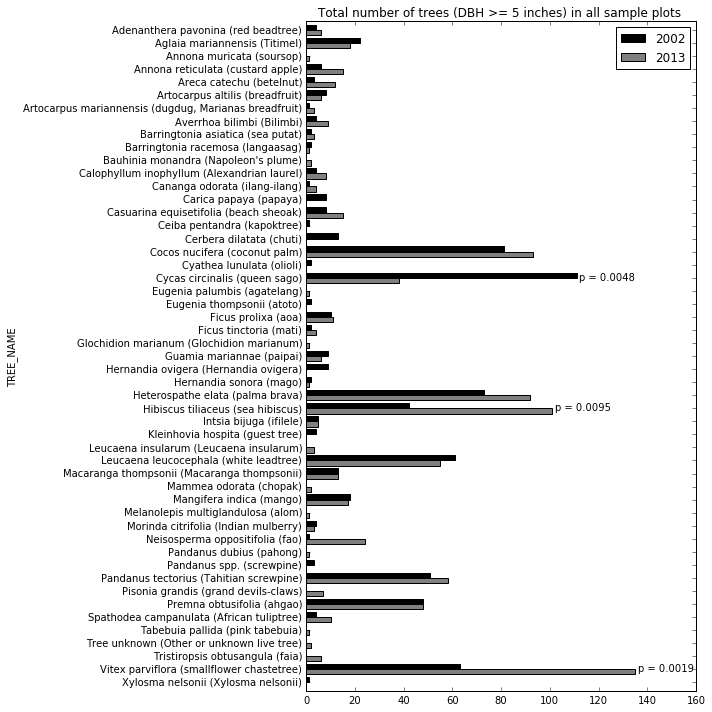

In [16]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
df_tree_counts_summary.plot(
    ax=ax,
    title='Total number of trees (DBH >= 5 inches) in all sample plots ',
    kind='barh',
    y=[2002,2013],
    figsize=(10, 10),
    width=0.8,
    color=['black','gray'],
    xlim=(0,160),
    legend=False,
).invert_yaxis()
ax.legend(["2002", "2013"])
dy=0.15; dx=1.0
ax.text(y=19+dy, x=111+dx, s='p = 0.0048')
ax.text(y=29+dy, x=101+dx, s='p = 0.0095')
ax.text(y=49+dy, x=135+dx, s='p = 0.0019');
fig.savefig('plot.pdf')